# Guided Hunting - Base64-Encoded Linux Commands

 <details>
     <summary>&nbsp;<u>Details...</u></summary>

 **Notebook Version:** 1.0<br>
 **Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
 **Required Packages**: kqlmagic, msticpy, pandas, numpy, matplotlib, networkx, seaborn, datetime, ipywidgets, ipython, dnspython, folium, maxminddb_geolite2, BeautifulSoup<br>
 **Platforms Supported**:
 - Azure Notebooks Free Compute
 - Azure Notebooks DSVM
 - OS Independent
 - Azure Machine Learning Notebooks

    
 **Data Sources Required**:
 - Log Analytics/Azure Sentinel - Syslog, Security Alerts, Auditd, Azure Network Analytics.
 - VirusTotal, AlienVault OTX, and IBM XForce require account and API key, which are free to create on their respective websites. If you'd prefer to use only one or prefer one over the others, there will be further instruction in the following sections.
 </details>

This notebook is a collection of tools for detecting malicious behavior when commands are Base64-encoded. It allows you to specify a workspace and time frame and will score and rank Base64 commands within those bounds.

It utilizes multiple data sources, primarily focusing on Azure Sentinel Syslog data augmented by telemetry from the MSTIC research branch of the AUOMS audit collection tool. Make sure to install this agent and connect your virtual machines with Azure Sentinel before using this notebook. For more on this, please see this [blog post](https://techcommunity.microsoft.com/t5/azure-sentinel/hunting-threats-on-linux-with-azure-sentinel/ba-p/1344431#).

This notebook also uses data from [GTFOBins](https://gtfobins.github.io/), a list of Unix binaries that can be exploited by attackers. These bash commands are labeled with preliminary functions that can help an investigator better understand what a command does.

Finally, we use TI intel from [AlienVaultOTX](https://otx.alienvault.com/), [VirusTotal](https://www.virustotal.com/gui/home/upload), and [IBM XForce](https://www.ibm.com/security/services/ibm-x-force-incident-response-and-intelligence) to highlight and emphasize certain Base64 commands. 

## Table of Contents

<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#Notebook-Setup" data-toc-modified-id="Notebook-Setup">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook Setup
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#Connect-to-Log-Analytics" data-toc-modified-id="Connect-to-Log-Analytics">
                        <span class="toc-item-num">1.1&nbsp;&nbsp;</span>Connect to Log Analytics and get Workspace ID
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#Set-Time-Parameters" data-toc-modified-id="Set-Time-Parameters">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>Set Time Parameters
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#Get-Base64-Commands" data-toc-modified-id="Get-Base64-Commands">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>Get Base64 Commands
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#Categorize-Decoded-Commands" data-toc-modified-id="Categorize-Decoded-Commands">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>Categorize Decoded Commands
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#GTFO-Bins-Classification" data-toc-modified-id="GTFO-Bins-Classification">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>GTFO Bins Classification
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#Generate-Scores-and-Rankings" data-toc-modified-id="Generate-Scores-and-Rankings">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>Generate Scores and Rankings
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#Frequency-Analysis" data-toc-modified-id="Frequency-Analysis">
                            <span class="toc-item-num">4.1&nbsp;&nbsp;</span>Frequency Analysis
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#Extract-IoCs" data-toc-modified-id="Extract-IoCs">
                            <span class="toc-item-num">4.2&nbsp;&nbsp;</span>Extract IoCs
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#Threat-Intelligence-Lookup" data-toc-modified-id="Threat-Intelligence-Lookup">
                            <span class="toc-item-num">4.3&nbsp;&nbsp;</span>Threat Intelligence Lookup
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#Related-Alerts" data-toc-modified-id="Related-Alerts">
                            <span class="toc-item-num">4.4&nbsp;&nbsp;</span>Related Alerts
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#Final-Scores-and-Rankings" data-toc-modified-id="Final-Scores-and-Rankings">
                    <span class="toc-item-num">5&nbsp;&nbsp;</span>Final Scores and Rankings
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#Behavior-Timeline" data-toc-modified-id="Behavior-Timeline">
                            <span class="toc-item-num">5.1&nbsp;&nbsp;</span>Behavior Timeline
                        </a>
                    </span>
                </li>
            </ul>
        </li>
    </ul>
</div>

## Notebook Setup

The next cell:
- Checks for the correct Python version
- Checks versions and optionally installs required packages
- Imports the required packages into the notebook
- Sets a number of configuration options.

This should complete without errors. If you encounter errors or warnings look at the following two notebooks:
- [TroubleShootingNotebooks](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/TroubleShootingNotebooks.ipynb)
- [ConfiguringNotebookEnvironment](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/ConfiguringNotebookEnvironment.ipynb)

If you are running in the Azure Sentinel Notebooks environment (Azure Notebooks or Azure ML) you can run live versions of these notebooks:
- [Run TroubleShootingNotebooks](./TroubleShootingNotebooks.ipynb)
- [Run ConfiguringNotebookEnvironment](./ConfiguringNotebookEnvironment.ipynb)

You may also need to do some additional configuration to successfully use functions such as Threat Intelligence service lookup and Geo IP lookup. 
There are more details about this in the `ConfiguringNotebookEnvironment` notebook and in these documents:
- [msticpy configuration](https://msticpy.readthedocs.io/en/latest/getting_started/msticpyconfig.html); This file is found in the same folder this notebook is in: [Azure Sentinel Notebooks](https://github.com/Azure/Azure-Sentinel-Notebooks).
- [Threat intelligence provider configuration](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html#configuration-file)

If you are unfamiliar with Jupyter notebooks, or want a more in-depth setup reference, check out these resources:
- [Getting Started with Azure Sentinel Notebooks Guide](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/A%20Getting%20Started%20Guide%20For%20Azure%20Sentinel%20Notebooks.ipynb)
- [Security Investigation with Azure Sentinel and Jupyter Notebooks - Part 1](https://techcommunity.microsoft.com/t5/azure-sentinel/security-investigation-with-azure-sentinel-and-jupyter-notebooks/ba-p/432921)
- [Why Use Jupyter for Security Investigations](https://msticpy.readthedocs.io/en/latest/getting_started/JupyterAndSecurity.html)


In [1]:
from pathlib import Path
import os
import sys
import warnings
from IPython.display import display, HTML, Markdown

REQ_PYTHON_VER=(3, 6)
REQ_MSTICPY_VER=(0, 6, 0)

display(HTML("<h3>Starting Notebook setup...</h3>"))
# If you did not clone the entire Azure-Sentinel-Notebooks repo you may not have this file
if Path("./utils/nb_check.py").is_file():
    from utils.nb_check import check_python_ver, check_mp_ver

    check_python_ver(min_py_ver=REQ_PYTHON_VER)
    try:
        check_mp_ver(min_msticpy_ver=REQ_MSTICPY_VER)
    except ImportError:
        !pip install --upgrade msticpy
        if "msticpy" in sys.modules:
            importlib.reload(sys.modules["msticpy"])
        else:
            import msticpy
        check_mp_ver(REQ_MSTICPY_VER)
            
from msticpy.nbtools import nbinit
nbinit.init_notebook(
    namespace=globals(),
    extra_imports=["ipwhois, IPWhois", "urllib.request, urlretrieve", "yaml"]
)

True

### Connect to Log Analytics

Run the cells below to connect to your Log Analytics workspace. If you haven't already, please fill in the relevant information in `msticpyconfig.yaml`. This file is found in the [Azure Sentinel Notebooks folder](https://github.com/Azure/Azure-Sentinel-Notebooks) this notebook is in. There is more information on how to do this in the Notebook Setup section above. You may need to restart the kernel after doing so and rerun any cells you've already run to update to the new information.

If you are unfamiliar with connecting to Log Analytics or want a more in-depth walkthrough, check out the [Getting Started with Azure Sentinel Notebook](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/A%20Getting%20Started%20Guide%20For%20Azure%20Sentinel%20Notebooks.ipynb).

In [2]:
# See if we have an Azure Sentinel Workspace defined in our config file.
# If not, let the user specify Workspace and Tenant IDs

ws_config = WorkspaceConfig()
if not ws_config.config_loaded:
    ws_config.prompt_for_ws()
    
qry_prov = QueryProvider(data_environment="AzureSentinel")
print("done")


Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done


In [3]:
# Authenticate to Azure Sentinel workspace
qry_prov.connect(ws_config)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Set Time Parameters

Run the cell below, then use the sliding bar that pops up to adjust the time frame in which you want the query to find Base64 commands.

#### Decide the time frame of your query

In [4]:
query_times = nbwidgets.QueryTime(units='day',
                                  max_before=20, max_after=1, before=3)
query_times.display()

## Get Base64 Commands

The following cell queries all Base64 commands in your Log Analytics workspace during the given time frame and queries data from AUOMS_EXECVE logs, which are discussed in this [blog post](https://techcommunity.microsoft.com/t5/azure-sentinel/hunting-threats-on-linux-with-azure-sentinel/ba-p/1344431#), which was mentioned earlier. This is the data the rest of the commands will run on. The query is written in KQL. If you would like to add additional information to the query results, you may do it here. Note that following cells rely on this output so the original columns must still be projected.

If you prefer to use a different log (not AUOMS_EXECVE), you may write your own query and will potentially have to edit certain values throughout the rest of the notebook to get the correct values and data frames.

In [5]:
pd.options.display.html.use_mathjax = False

query = "Syslog" + f""" | where TimeGenerated between (datetime({query_times.start}) .. datetime({query_times.end})) """ + r""" 
| parse SyslogMessage with "type=" EventType " audit(" * "): " EventData
| project TimeGenerated, EventType, Computer, EventData 
| where EventType == "AUOMS_EXECVE"
| parse EventData with * "cmdline=" Cmdline " containerid=" containerid
| where Cmdline has "base64" and Cmdline has "echo"
| where Cmdline matches regex "^(.*)([A-Za-z0-9])(.*)$"
| parse kind=regex Cmdline with * "echo\\s*(-n\\s)?\\\\?[\"']?" cmdextract "\\\\?[\"']?[\\s\"'$]"
| extend cmdextract= trim_end(@"(\\?)(\'?)(\s?)(\|)(\s?)(.*)(base64)(.*)",cmdextract)
| extend DecodedCommand=base64_decode_tostring(cmdextract)
| project TimeGenerated, Computer, Cmdline, DecodedCommand
"""

print("Collecting base64 queries...")
b64_df= qry_prov.exec_query(query)
b64_df

<IPython.core.display.Javascript object>

,TimeGenerated,Computer,Cmdline,DecodedCommand
0,2021-08-11 13:55:20.787000+00:00,AUMOS-Box,"""sh -c ""echo ZmluZCAvZXRjL2Nyb24qIApmaW5kIC92YXIvc3Bvb2wvY3JvbiogCmdyZXAgLXEgbWF6ZSAgL2V0Yy9ob3N...",find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngr...
1,2021-08-11 13:56:31.277000+00:00,AUMOS-Box,"""sh -c ""echo Y3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQvZ2V0dHkgL2Jpbi9wcyAKY3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQ...",cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bi...
2,2021-08-11 13:57:08.507000+00:00,AUMOS-Box,"""sh -c $'echo bWtkaXIgc25lYWt5ZmlsZQpjaG1vZCA3NTUgc25lYWt5ZmlsZQpj\n\nZCBzbmVha3lmaWxlCnRvdWNoIH...",
3,2021-08-11 14:06:24.337000+00:00,AUMOS-Box,"""sh -c $'echo ZmluZCAvZXRjL2Nyb24qCgpmaW5kIC92YXIvc3Bvb2wvY3JvbioKCmdyZXAgLXEgbWF6ZSAgL2V0\nYy9o...",
4,2021-08-11 14:07:06.460000+00:00,AUMOS-Box,"""sh -c ""echo ZmluZCAvZXRjL2Nyb24qCgpmaW5kIC92YXIvc3Bvb2wvY3JvbioKCmdyZXAgLXEgbWF6ZSAgL2V0Yy9ob3N...",
5,2021-08-11 14:07:22.620000+00:00,AUMOS-Box,"""sh -c ""echo ZmluZCAvZXRjL2Nyb24qCgpmaW5kIC92YXIvc3Bvb2wvY3JvbioKCmdyZXAgLXEgbWF6ZSAgL2V0Yy9ob3N...",
6,2021-08-13 20:41:29.867000+00:00,AUOMS-Ubuntu20,"""sh -c ""echo Y3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQvZ2V0dHkgL2Jpbi9wcyAKY3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQ...",
7,2021-08-13 20:41:30.440000+00:00,AUOMS-Ubuntu20,"""sh -c ""echo Y3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQvZ2V0dHkgL2Jpbi9wcyAKY3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQ...",
8,2021-08-13 20:41:30.723000+00:00,AUOMS-Ubuntu20,"""sh -c ""echo Y3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQvZ2V0dHkgL2Jpbi9wcyAKY3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQ...",
9,2021-08-13 20:41:30.990000+00:00,AUOMS-Ubuntu20,"""sh -c ""echo Y3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQvZ2V0dHkgL2Jpbi9wcyAKY3AgLWYgL3Vzci9iaW4vYnNkLXBvcnQ...",


### Basic Command Categorization

We will be categorizing commands in two ways: this cell categorizes commands by looking for commonly used commands we are aware of. The next section will use an open source compilation.

This cell categorizes each decoded Base64 command by functionality based on what bash commands are present in the decoded version. For example, commands with "wget" or "curl" in them are categorized as "Network connections/Downloading." Other categories include "File Manipulation", "Host Enumeration", and "File/Process deletion/killing."

This categorization is by no means exhaustive. Feel free to add commands and categories to our basic one.

In [6]:
# Network connections/downloading (wget, curl, urllib.urlopen) 
# File manipulation (chmod, chattr, touch, cp, mv, ln, sed, awk, echo)
# Host enumeration (uname, grep … /proc/cpuinfo) 
# File/process deletion/killing (rm, pkill) 
# Archive/compression programs (tar, zip, gzip, bzip2, lzma, xz)

def categorize(cmds):
    ret = []
    for cmd in cmds:
        categories = []
        if ("wget" in cmd) or ("curl" in cmd) or ("urllib.urlopen" in cmd):
            categories.append("network connections/downloading")
        if ("chmod" in cmd) or ("chattr" in cmd) or ("touch" in cmd) or ("cp" in cmd) or ("mv" in cmd) or ("ln" in cmd) or ("sed" in cmd) or ("awk" in cmd) or ("echo" in cmd):
            categories.append("file manipulation")
        if ("uname" in cmd) or ("grep" in cmd) or ("/proc/cpuinfo" in cmd):
            categories.append("host enumeration")
        if ("rm" in cmd) or ("pkill" in cmd):
            categories.append("file/process deletion/killing")
        if ("tar" in cmd) or ("zip" in cmd) or ("gzip" in cmd) or ("bzip2" in cmd) or ("lzma" in cmd) or ("xz" in cmd):
            categories.append("archive/compression programs")
        ret.append(categories)
    return ret

print("Categorizing commands...")
b64_df['Categories'] = categorize(b64_df['DecodedCommand'])
b64_df['Categories'] = b64_df['Categories'].apply(str)  # For drop_duplicates to work
b64_df[["Computer", "DecodedCommand", "Categories"]].drop_duplicates()

Categorizing commands...


,Computer,DecodedCommand,Categories
0,AUMOS-Box,find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngr...,"['file manipulation', 'host enumeration', 'file/process deletion/killing']"
1,AUMOS-Box,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bi...,"['network connections/downloading', 'file manipulation', 'host enumeration', 'file/process delet..."
2,AUMOS-Box,,[]
6,AUOMS-Ubuntu20,,[]
15,AUOMS-Ubuntu20,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bi...,"['network connections/downloading', 'file manipulation', 'host enumeration', 'file/process delet..."
21,AUOMS-Ubuntu20,find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngr...,"['file manipulation', 'host enumeration', 'file/process deletion/killing']"
28,AUOMS-Ubuntu20,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116...",['file manipulation']
35,AUOMS-Ubuntu20,mkdir sneakyfile\nchmod 755 sneakyfile\ncd sneakyfile\ntouch testing\nlsattr -R \ncd ..\nrm -r s...,"['file manipulation', 'file/process deletion/killing']"


### GTFO Bins Classification

This cell categorizes the commands based on [GTFOBins](https://gtfobins.github.io/). GTFOBins is a vetted collection of bash commands frequently exploited by attackers as well as a reference as to how those commands may be used. We are using it to find potentially exploited commands in the dataset and tag those with their corresponding functionalities.

Run the cell below to read about what each category means according to the GTFOBins website.

In [7]:
from requests import get
from bs4 import BeautifulSoup


# Get HTML content from GTFOBins Website
fn_url = 'https://gtfobins.github.io/functions/'
fn_response = get(fn_url)

fn_soup = BeautifulSoup(fn_response.text, 'html.parser')
function_names = fn_soup.find_all('dt', class_ = 'function-name')
function_descriptions = fn_soup.find_all('dd')

display(HTML("<h1>GTFOBins Functions</h1>"))

# Print function headings and descriptions
for fn in range(len(function_descriptions)):
    display(HTML(f"<b>{function_names[fn].text}</b>:&nbsp;{function_descriptions[fn].text}<br>")) 

The following cell tags commands with GTFOBins bins and functions and displays the dataframe again for viewing. You may click on the links in the 'GTFO Bins' column for easy access to the GTFOBins website and more information.

In [8]:
# Get GTFOBins bins from the website and create a list
print("Getting GTFO Bins...")
url = 'https://gtfobins.github.io/'
response = get(url)
gtfo_soup = BeautifulSoup(response.text, 'html.parser')
gtfo_cmds = gtfo_soup.find_all('a', class_ = 'bin-name')
gtfobinsList = [cmd.text for cmd in gtfo_cmds]

# Get the GTFO functions corresponding to each bin
print("Getting GTFO Functions...")
binsFunctions = []
for b in gtfobinsList:
    bin_url = 'https://gtfobins.github.io/gtfobins/' + b
    bin_response = get(bin_url)
    bin_soup = BeautifulSoup(bin_response.text, 'html.parser')
    bin_fnnames = bin_soup.find_all('h2', class_ = 'function-name')
    names = [n.text for n in bin_fnnames]
    binsFunctions.append(names)

# Create a dictionary where the keys are bins and the values are its functions
binsDict = dict(zip(gtfobinsList, binsFunctions))

# Return lists of bins and functions corresponding to each command
def getGtfoBins(cmds):
    retBins = []
    retFns = []
    for cmd in cmds:
        bins_matched = []
        fns_matched = set()
        for b in binsDict.keys():
            if b in cmd:
                bins_matched.append('<a href="https://gtfobins.github.io/gtfobins/' + b + '">' + b + '</a>')
                fns_matched.update(binsDict[b])
        retBins.append(bins_matched)
        retFns.append(fns_matched)  
    return retBins, retFns

print("Tagging GTFOBins...")
GTFOResult = getGtfoBins(b64_df['DecodedCommand'])

print("Formatting result...")
b64_df['GTFO Bins'] = GTFOResult[0]
b64_df['GTFO Functions'] = GTFOResult[1]

b64_df['GTFO Bins'] = b64_df['GTFO Bins'].apply(str) # For drop_duplicates
b64_df['GTFO Functions'] = b64_df['GTFO Functions'].apply(str)

HTML(b64_df[[ 'GTFO Bins', 'GTFO Functions', 'Computer', 'DecodedCommand', 'Categories']].drop_duplicates().to_html(escape=False))

Getting GTFO Bins...
Getting GTFO Functions...
Tagging GTFOBins...
Formatting result...


,GTFO Bins,GTFO Functions,Computer,DecodedCommand,Categories
0,"['ar', 'ash', 'at', 'awk', 'bash', 'eb', 'file', 'find', 'grep', 'paste', 'pr', 'sort', 'ss', 'ssh', 'uniq']","{'File upload', 'Limited SUID', 'Shell', 'Library load', 'File download', 'Command', 'Non-interactive bind shell', 'Non-interactive reverse shell', 'File write', 'Sudo', 'Reverse shell', 'SUID', 'File read'}",AUMOS-Box,"find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngrep -q ""0.0.0.0 pastebin.com"" /etc/hosts\nnetstat -antp|grep -E ""0.0.0.0"" \ngrep -oE ""\b([0-9]{1,3}\.){3}[0-9]{1,3}\b"" ~/.bash_history /etc/hosts ~/.ssh/known_hosts |awk -F: {'print $2'}|sort|uniq \necho ""new file"" > testfile \ntouch -r /bin/grep testfile \nrm testfile","['file manipulation', 'host enumeration', 'file/process deletion/killing']"
1,"['at', 'cp', 'grep', 'pg', 'watch', 'wget']","{'File upload', 'Limited SUID', 'Shell', 'File download', 'Command', 'File write', 'Sudo', 'SUID', 'File read'}",AUMOS-Box,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bin/bsd-port/getty \ncp -f /usr/bin/bsd-port/getty /bin/netstat \npgrep -f cryptonight \ngrep xmr.crypto-pool.fr:443 \ngrep kthrotlds \npgrep -f ./watchbog \npkill -f cryptonight \ngrep mine.moneropool.com \npgrep -f IyEvYmluL3NoCgpzUG \nwget,"['network connections/downloading', 'file manipulation', 'host enumeration', 'file/process deletion/killing']"
2,[],set(),AUMOS-Box,,[]
6,[],set(),AUOMS-Ubuntu20,,[]
15,"['at', 'cp', 'grep', 'pg', 'watch', 'wget']","{'File upload', 'Limited SUID', 'Shell', 'File download', 'Command', 'File write', 'Sudo', 'SUID', 'File read'}",AUOMS-Ubuntu20,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bin/bsd-port/getty \ncp -f /usr/bin/bsd-port/getty /bin/netstat \npgrep -f cryptonight \ngrep xmr.crypto-pool.fr:443 \ngrep kthrotlds \npgrep -f ./watchbog \npkill -f cryptonight \ngrep mine.moneropool.com \npgrep -f IyEvYmluL3NoCgpzUG \nwget,"['network connections/downloading', 'file manipulation', 'host enumeration', 'file/process deletion/killing']"
21,"['ar', 'ash', 'at', 'awk', 'bash', 'eb', 'file', 'find', 'grep', 'paste', 'pr', 'sort', 'ss', 'ssh', 'uniq']","{'File upload', 'Limited SUID', 'Shell', 'Library load', 'File download', 'Command', 'Non-interactive bind shell', 'Non-interactive reverse shell', 'File write', 'Sudo', 'Reverse shell', 'SUID', 'File read'}",AUOMS-Ubuntu20,"find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngrep -q ""0.0.0.0 pastebin.com"" /etc/hosts\nnetstat -antp|grep -E ""0.0.0.0"" \ngrep -oE ""\b([0-9]{1,3}\.){3}[0-9]{1,3}\b"" ~/.bash_history /etc/hosts ~/.ssh/known_hosts |awk -F: {'print $2'}|sort|uniq \necho ""new file"" > testfile \ntouch -r /bin/grep testfile \nrm testfile\n","['file manipulation', 'host enumeration', 'file/process deletion/killing']"
28,[],set(),AUOMS-Ubuntu20,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116.203.73.240|131.153.56.98|131.153.76.130|136.243.102.154|138.201.20.89|138.201.27.243|138.201.36.249|139.162.132.70|139.162.60.220|139.162.81.90|139.99.101.197|139.99.101.198|139.99.101.232|139.99.102.70|139.99.102.71|139.99.102.72|139.99.102.73|139.99.102.74|139.99.120.50|139.99.120.75|""",['file manipulation']
35,"['at', 'chmod', 'file', 'od']","{'Shell', 'Command', 'Sudo', 'SUID', 'File read'}",AUOMS-Ubuntu20,mkdir sneakyfile\nchmod 755 sneakyfile\ncd sneakyfile\ntouch testing\nlsattr -R \ncd ..\nrm -r sneakyfile,"['file manipulation', 'file/process deletion/killing']"


## Generate Scores and Rankings

The following sections generate scores for each unique Base64 command based on criteria such as frequency of the command, severity of TI lookup results, and related commands run. Each score is added to the dataframe at the end, so you can view and rank each individually or by the aggregate score.

Scores are somewhat artificially created and are meant to help investigators understand and highlight commands that are more likely to be malicious. They do not represent any mathematical value and are not calculated in comparison to any particular number other than each other, where higher scores are more likely to be malicious commands.

### Frequency Analysis

The cell below creates a frequency score for each unique Base64 command by calculating (1 / # times command occured in the workspace). It then adds an additional score calculated by (1 / # times command occured in its host computer). Both of these scores are divided by 2 for normalization purposes.

This results in rarer commands getting higher scores.

In [9]:
# Calculate Frequency Scores for the given data frame column 
def calcFreqScore(df):
    return 1 / df

def num_unique(col):
    return len(col.unique())

# Aggregate b64_df column 
b64_analytics = b64_df[["TimeGenerated", "Computer", "DecodedCommand", "Categories", "GTFO Bins", "GTFO Functions"]].groupby("DecodedCommand").agg(
    CommandCount=pd.NamedAgg(column="DecodedCommand", aggfunc="count"),
    TotalHosts=pd.NamedAgg(column="Computer", aggfunc=num_unique),
    Hostnames=pd.NamedAgg(column="Computer", aggfunc="unique"),
    Categories= pd.NamedAgg(column="Categories", aggfunc="first"),
    GTFOBins=pd.NamedAgg(column="GTFO Bins", aggfunc="first"),
    GTFOFunctions=pd.NamedAgg(column="GTFO Functions", aggfunc="first"),
    FirstSeen=pd.NamedAgg(column="TimeGenerated", aggfunc="min"),
    LastSeen=pd.NamedAgg(column="TimeGenerated", aggfunc="max"),
).reset_index()

b64_analytics["FreqScore"] = calcFreqScore(b64_analytics["CommandCount"]) / 2
b64_analytics["FreqScore"] = b64_analytics["FreqScore"] + ((calcFreqScore(b64_analytics["TotalHosts"])) / 2)
b64_analytics["TotalScore"] = b64_analytics["FreqScore"]

# Display
display_cols = [
    'TotalScore','FreqScore', 'DecodedCommand', 'CommandCount', 'TotalHosts', 
    'Hostnames', 'Categories', 'GTFOBins', 'GTFOFunctions', 'FirstSeen', 'LastSeen'
]
summary_df = (
    b64_analytics[display_cols].sort_values("TotalScore", ascending=False).reset_index().drop(['index'], axis=1)
)
HTML(summary_df.to_html(escape=False))

,TotalScore,FreqScore,DecodedCommand,CommandCount,TotalHosts,Hostnames,Categories,GTFOBins,GTFOFunctions,FirstSeen,LastSeen
0,1.000000,1.000000,"find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngrep -q ""0.0.0.0 pastebin.com"" /etc/hosts\nnetstat -antp|grep -E ""0.0.0.0"" \ngrep -oE ""\b([0-9]{1,3}\.){3}[0-9]{1,3}\b"" ~/.bash_history /etc/hosts ~/.ssh/known_hosts |awk -F: {'print $2'}|sort|uniq \necho ""new file"" > testfile \ntouch -r /bin/grep testfile \nrm testfile",1,1,[AUMOS-Box],"['file manipulation', 'host enumeration', 'file/process deletion/killing']","['ar', 'ash', 'at', 'awk', 'bash', 'eb', 'file', 'find', 'grep', 'paste', 'pr', 'sort', 'ss', 'ssh', 'uniq']","{'File upload', 'Limited SUID', 'Shell', 'Library load', 'File download', 'Command', 'Non-interactive bind shell', 'Non-interactive reverse shell', 'File write', 'Sudo', 'Reverse shell', 'SUID', 'File read'}",2021-08-11 13:55:20.787000+00:00,2021-08-11 13:55:20.787000+00:00
1,0.600000,0.600000,mkdir sneakyfile\nchmod 755 sneakyfile\ncd sneakyfile\ntouch testing\nlsattr -R \ncd ..\nrm -r sneakyfile,5,1,[AUOMS-Ubuntu20],"['file manipulation', 'file/process deletion/killing']","['at', 'chmod', 'file', 'od']","{'Shell', 'Command', 'Sudo', 'SUID', 'File read'}",2021-08-13 21:41:47.017000+00:00,2021-08-13 21:41:56.410000+00:00
2,0.571429,0.571429,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116.203.73.240|131.153.56.98|131.153.76.130|136.243.102.154|138.201.20.89|138.201.27.243|138.201.36.249|139.162.132.70|139.162.60.220|139.162.81.90|139.99.101.197|139.99.101.198|139.99.101.232|139.99.102.70|139.99.102.71|139.99.102.72|139.99.102.73|139.99.102.74|139.99.120.50|139.99.120.75|""",7,1,[AUOMS-Ubuntu20],['file manipulation'],[],set(),2021-08-13 21:50:09.230000+00:00,2021-08-13 21:50:13.493000+00:00
3,0.571429,0.571429,"find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngrep -q ""0.0.0.0 pastebin.com"" /etc/hosts\nnetstat -antp|grep -E ""0.0.0.0"" \ngrep -oE ""\b([0-9]{1,3}\.){3}[0-9]{1,3}\b"" ~/.bash_history /etc/hosts ~/.ssh/known_hosts |awk -F: {'print $2'}|sort|uniq \necho ""new file"" > testfile \ntouch -r /bin/grep testfile \nrm testfile\n",7,1,[AUOMS-Ubuntu20],"['file manipulation', 'host enumeration', 'file/process deletion/killing']","['ar', 'ash', 'at', 'awk', 'bash', 'eb', 'file', 'find', 'grep', 'paste', 'pr', 'sort', 'ss', 'ssh', 'uniq']","{'File upload', 'Limited SUID', 'Shell', 'Library load', 'File download', 'Command', 'Non-interactive bind shell', 'Non-interactive reverse shell', 'File write', 'Sudo', 'Reverse shell', 'SUID', 'File read'}",2021-08-13 21:42:53.073000+00:00,2021-08-13 21:42:58.077000+00:00
4,0.333333,0.333333,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bin/bsd-port/getty \ncp -f /usr/bin/bsd-port/getty /bin/netstat \npgrep -f cryptonight \ngrep xmr.crypto-pool.fr:443 \ngrep kthrotlds \npgrep -f ./watchbog \npkill -f cryptonight \ngrep mine.moneropool.com \npgrep -f IyEvYmluL3NoCgpzUG \nwget,6,2,"[AUMOS-Box, AUOMS-Ubuntu20]","['network connections/downloading', 'file manipulation', 'host enumeration', 'file/process deletion/killing']","['at', 'cp', 'grep', 'pg', 'watch', 'wget']","{'File upload', 'Limited SUID', 'Shell', 'File download', 'Command', 'File write', 'Sudo', 'SUID', 'File read'}",2021-08-11 13:56:31.277000+00:00,2021-08-13 21:41:09.207000+00:00
5,0.285714,0.285714,,14,2,"[AUMOS-Box, AUOMS-Ubuntu20]",[],[],set(),2021-08-11 13:57:08.507000+00:00,2021-08-13 21:42:08.327000+00:00


### Extract IoCs

The cell below extracts any IoCs from the decoded Base64 commands and adds them to the dataframe. It uses the MSTICpy IoC extraction features, which extract the following patterns:
- ipv4
- ipv6
- dns
- url
- windows_path
- linux_path
- md5_hash
- sha1_hash
- sha256_hash

If you want to look for an IoC pattern that is not included, here feel free to modify the MSTICpy class. See [this link](https://msticpy.readthedocs.io/en/latest/data_analysis/IoCExtract.html?) for more information.

In [10]:
ioc_extractor = IoCExtract()

ioc_df = ioc_extractor.extract(data=b64_analytics, columns=['DecodedCommand'])

if len(ioc_df):
    display(HTML("<h3>IoC patterns found in process tree.</h3>"))
    display(ioc_df)

,IoCType,Observable,SourceIndex,Input
0,dns,xmr.crypto-pool.fr,1,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bi...
1,dns,mine.moneropool.com,1,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bi...
2,ipv4,139.99.120.50,2,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116..."
3,ipv4,107.191.99.95,2,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116..."
4,ipv4,139.99.102.73,2,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116..."
5,ipv4,139.99.102.71,2,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116..."
6,ipv4,138.201.27.243,2,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116..."
7,ipv4,139.99.102.70,2,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116..."
8,ipv4,139.99.101.198,2,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116..."
9,ipv4,139.99.120.75,2,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116..."


### Threat Intelligence Lookup

Load and run TILookup on IoCs found. Make sure you configure `msticpyconfig.yaml` with the appropriate TI sources. Check out the document below if you need help with this) process.
- [TI Configuration File](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html#configuration-file)

We highly encourage you to add TI sources, but if you don't have any (i.e. API keys from AlienVault OTX, IBM XForce, or VirusTotal) and don't want to make accounts, you can skip this section and go to directly to [Related Alerts Scoring](#Related-Alerts) below. Your rankings will be based exclusively on frequency scores and related alerts scoring in this case. 

#### Confirm TI Sources

The below code will print out your current TI Lookup configurations. 

In [11]:
ti_lookup = TILookup()

ti_lookup.reload_providers()
if not ti_lookup.provider_status:
    md_warn("You have no TI providers configured, please see the documentation link above.")


Settings reloaded. Use reload_providers to update settings for loaded providers.


Choose which providers you would like to use during the TI lookup. You will need these to be configured on `msticpyconfig.yaml`. Additional directions given above in the Notebook Setup section.

In [12]:
providers = [t.split(' - ', 1)[0] for t in ti_lookup.provider_status]
providers_ss = nbwidgets.SelectSubset(
    providers,
    default_selected=['OTX', 'VirusTotal', 'XForce']
)

#### Choose IoCs to look up

You can choose IoCs you're interested in to look up or look up all of them for scoring. Scores will be based exclusively on the Severity column. The following cells will also print a TI dataframe with added information.

In [13]:
items = ioc_df["Observable"].values
ioc_ss = nbwidgets.SelectSubset(
    items,
    default_selected=items.all()
)

Run this cell to look up the selected IoCs above.

In [14]:
iocs_to_check = (ioc_df[ioc_df["Observable"].isin(ioc_ss.selected_items)]
                 [["IoCType", "Observable"]].drop_duplicates())

print("Looking up IoCs...")
ti_results = ti_lookup.lookup_iocs(data=iocs_to_check, obs_col="Observable", providers=providers_ss.selected_items)

ti_results

Looking up IoCs...


,Ioc,IocType,SafeIoc,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,xmr.crypto-pool.fr,dns,xmr.crypto-pool.fr,None,OTX,True,information,"{'pulse_count': 0, 'sections_available': ['general', 'geo', 'url_list', 'passive_dns', 'malware'...","{'sections': ['general', 'geo', 'url_list', 'passive_dns', 'malware', 'whois', 'http_scans'], 'w...",https://otx.alienvault.com/api/v1/indicators/domain/xmr.crypto-pool.fr/general,0
1,mine.moneropool.com,dns,mine.moneropool.com,None,OTX,True,information,"{'pulse_count': 0, 'sections_available': ['general', 'geo', 'url_list', 'passive_dns', 'malware'...","{'sections': ['general', 'geo', 'url_list', 'passive_dns', 'malware', 'whois', 'http_scans'], 'w...",https://otx.alienvault.com/api/v1/indicators/domain/mine.moneropool.com/general,0
2,139.99.120.50,ipv4,139.99.120.50,None,OTX,True,high,"{'pulse_count': 15, 'names': ['Webscanners 2018-02-09 thru current day', 'Malware Command and C...","{'whois': 'http://whois.domaintools.com/139.99.120.50', 'reputation': 0, 'indicator': '139.99.12...",https://otx.alienvault.com/api/v1/indicators/IPv4/139.99.120.50/general,0
3,107.191.99.95,ipv4,107.191.99.95,None,OTX,True,high,"{'pulse_count': 19, 'names': ['Malware Command and Control IPs', 'Stacey Grubb', 'Stacey Grubb',...","{'whois': 'http://whois.domaintools.com/107.191.99.95', 'reputation': 0, 'indicator': '107.191.9...",https://otx.alienvault.com/api/v1/indicators/IPv4/107.191.99.95/general,0
4,139.99.102.73,ipv4,139.99.102.73,None,OTX,True,high,"{'pulse_count': 17, 'names': ['Malware Command and Control IPs', 'Stacey Grubb', 'Stacey Grubb',...","{'whois': 'http://whois.domaintools.com/139.99.102.73', 'reputation': 0, 'indicator': '139.99.10...",https://otx.alienvault.com/api/v1/indicators/IPv4/139.99.102.73/general,0
5,139.99.102.71,ipv4,139.99.102.71,None,OTX,True,high,"{'pulse_count': 17, 'names': ['Malware Command and Control IPs', 'Stacey Grubb', 'Stacey Grubb',...","{'whois': 'http://whois.domaintools.com/139.99.102.71', 'reputation': 0, 'indicator': '139.99.10...",https://otx.alienvault.com/api/v1/indicators/IPv4/139.99.102.71/general,0
6,138.201.27.243,ipv4,138.201.27.243,None,OTX,True,high,"{'pulse_count': 12, 'names': ['Malware Command and Control IPs', 'DominionVotingSystem.com - Upd...","{'whois': 'http://whois.domaintools.com/138.201.27.243', 'reputation': 0, 'indicator': '138.201....",https://otx.alienvault.com/api/v1/indicators/IPv4/138.201.27.243/general,0
7,139.99.102.70,ipv4,139.99.102.70,None,OTX,True,high,"{'pulse_count': 18, 'names': ['Malware Command and Control IPs', 'Stacey Grubb', 'Stacey Grubb',...","{'whois': 'http://whois.domaintools.com/139.99.102.70', 'reputation': 0, 'indicator': '139.99.10...",https://otx.alienvault.com/api/v1/indicators/IPv4/139.99.102.70/general,0
8,139.99.101.198,ipv4,139.99.101.198,None,OTX,True,high,"{'pulse_count': 17, 'names': ['Malware Command and Control IPs', 'Stacey Grubb', 'Stacey Grubb',...","{'whois': 'http://whois.domaintools.com/139.99.101.198', 'reputation': 0, 'indicator': '139.99.1...",https://otx.alienvault.com/api/v1/indicators/IPv4/139.99.101.198/general,0
9,139.99.120.75,ipv4,139.99.120.75,None,OTX,True,high,"{'pulse_count': 13, 'names': ['A mining multitool', 'Malware Command and Control IPs', 'Stacey G...","{'whois': 'http://whois.domaintools.com/139.99.120.75', 'reputation': 0, 'indicator': '139.99.12...",https://otx.alienvault.com/api/v1/indicators/IPv4/139.99.120.75/general,0


#### Calculate TI Severity Scores

The following cell uses the most severe of the severity scores provided by the providers to add to each score. The more severe the IoC found, the higher the score the command will receive. Each unique IoC found will add to the score of that command.

In [15]:
# Define severity scores
sev_scores = {"information": 0, "low": 1, "medium": 1.5, "high": 3, "unknown":1}

# Calculate severity scores and add iocs to the data frame
def calc_severity(cmds):
    ret_iocs = []
    ret_scores =[]
    for c in cmds:
        c_iocs = set()
        c_sev_score = []
        for ioc in ioc_df['Observable']:
            if ioc in c:
                c_iocs.add(ioc)
        for uniq_ioc in c_iocs:
            sev_df = ti_results[ti_results['Ioc'].values == uniq_ioc]
            
            # Add severities for selected providers
            az_sev = ""
            otx_sev = ""
            vt_sev = ""
            xf_sev = ""
            if 'AzSTI' in providers_ss.selected_items:
                az_sev = str(sev_df[sev_df['Provider'] == 'AzSTI']['Severity'])
            if 'OTX' in providers_ss.selected_items:
                otx_sev = str(sev_df[sev_df['Provider'] == 'OTX']['Severity'])
            if 'VirusTotal' in providers_ss.selected_items:
                vt_sev = str(sev_df[sev_df['Provider'] == 'VirusTotal']['Severity'])
            if 'Xforce' in providers_ss.selected_items:
                xf_sev = str(sev_df[sev_df['Provider'] == 'XForce']['Severity'])
                
            # Add scores 
            if 'high' in otx_sev or 'high' in vt_sev or 'high' in xf_sev:
                c_sev_score.append(sev_scores['high'])
            elif 'medium' in otx_sev or 'medium' in vt_sev or 'medium' in xf_sev:
                c_sev_score.append(sev_scores['medium'])
            elif 'low' in otx_sev or 'low' in vt_sev or 'low' in xf_sev:
                c_sev_score.append(sev_scores['low'])
            elif 'info' in otx_sev or 'info' in vt_sev or 'info' in xf_sev:
                c_sev_score.append(sev_scores['information'])
            else:
                c_sev_score.append(sev_scores['unknown'])
        ret_iocs.append(c_iocs)
        ret_scores.append(sum(c_sev_score))
    
    return ret_iocs, ret_scores
        
ti_info = calc_severity(b64_analytics['DecodedCommand'])
b64_analytics['IoCsFound'] = ti_info[0]
b64_analytics['SevScore'] = ti_info[1]
b64_analytics['TotalScore'] += b64_analytics['SevScore']

display_cols = [
    'TotalScore','SevScore','FreqScore', 'DecodedCommand', 'CommandCount', 'TotalHosts', 
    'Hostnames', 'Categories', 'GTFOBins', 'GTFOFunctions', 'FirstSeen', 'LastSeen'
]
summary_df = (
    b64_analytics[display_cols].sort_values("TotalScore", ascending=False).reset_index().drop(['index'], axis=1)
)
HTML(summary_df.to_html(escape=False))

,TotalScore,SevScore,FreqScore,DecodedCommand,CommandCount,TotalHosts,Hostnames,Categories,GTFOBins,GTFOFunctions,FirstSeen,LastSeen
0,76.571429,76,0.571429,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116.203.73.240|131.153.56.98|131.153.76.130|136.243.102.154|138.201.20.89|138.201.27.243|138.201.36.249|139.162.132.70|139.162.60.220|139.162.81.90|139.99.101.197|139.99.101.198|139.99.101.232|139.99.102.70|139.99.102.71|139.99.102.72|139.99.102.73|139.99.102.74|139.99.120.50|139.99.120.75|""",7,1,[AUOMS-Ubuntu20],['file manipulation'],[],set(),2021-08-13 21:50:09.230000+00:00,2021-08-13 21:50:13.493000+00:00
1,5.000000,4,1.000000,"find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngrep -q ""0.0.0.0 pastebin.com"" /etc/hosts\nnetstat -antp|grep -E ""0.0.0.0"" \ngrep -oE ""\b([0-9]{1,3}\.){3}[0-9]{1,3}\b"" ~/.bash_history /etc/hosts ~/.ssh/known_hosts |awk -F: {'print $2'}|sort|uniq \necho ""new file"" > testfile \ntouch -r /bin/grep testfile \nrm testfile",1,1,[AUMOS-Box],"['file manipulation', 'host enumeration', 'file/process deletion/killing']","['ar', 'ash', 'at', 'awk', 'bash', 'eb', 'file', 'find', 'grep', 'paste', 'pr', 'sort', 'ss', 'ssh', 'uniq']","{'File upload', 'Limited SUID', 'Shell', 'Library load', 'File download', 'Command', 'Non-interactive bind shell', 'Non-interactive reverse shell', 'File write', 'Sudo', 'Reverse shell', 'SUID', 'File read'}",2021-08-11 13:55:20.787000+00:00,2021-08-11 13:55:20.787000+00:00
2,4.571429,4,0.571429,"find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngrep -q ""0.0.0.0 pastebin.com"" /etc/hosts\nnetstat -antp|grep -E ""0.0.0.0"" \ngrep -oE ""\b([0-9]{1,3}\.){3}[0-9]{1,3}\b"" ~/.bash_history /etc/hosts ~/.ssh/known_hosts |awk -F: {'print $2'}|sort|uniq \necho ""new file"" > testfile \ntouch -r /bin/grep testfile \nrm testfile\n",7,1,[AUOMS-Ubuntu20],"['file manipulation', 'host enumeration', 'file/process deletion/killing']","['ar', 'ash', 'at', 'awk', 'bash', 'eb', 'file', 'find', 'grep', 'paste', 'pr', 'sort', 'ss', 'ssh', 'uniq']","{'File upload', 'Limited SUID', 'Shell', 'Library load', 'File download', 'Command', 'Non-interactive bind shell', 'Non-interactive reverse shell', 'File write', 'Sudo', 'Reverse shell', 'SUID', 'File read'}",2021-08-13 21:42:53.073000+00:00,2021-08-13 21:42:58.077000+00:00
3,0.600000,0,0.600000,mkdir sneakyfile\nchmod 755 sneakyfile\ncd sneakyfile\ntouch testing\nlsattr -R \ncd ..\nrm -r sneakyfile,5,1,[AUOMS-Ubuntu20],"['file manipulation', 'file/process deletion/killing']","['at', 'chmod', 'file', 'od']","{'Shell', 'Command', 'Sudo', 'SUID', 'File read'}",2021-08-13 21:41:47.017000+00:00,2021-08-13 21:41:56.410000+00:00
4,0.333333,0,0.333333,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bin/bsd-port/getty \ncp -f /usr/bin/bsd-port/getty /bin/netstat \npgrep -f cryptonight \ngrep xmr.crypto-pool.fr:443 \ngrep kthrotlds \npgrep -f ./watchbog \npkill -f cryptonight \ngrep mine.moneropool.com \npgrep -f IyEvYmluL3NoCgpzUG \nwget,6,2,"[AUMOS-Box, AUOMS-Ubuntu20]","['network connections/downloading', 'file manipulation', 'host enumeration', 'file/process deletion/killing']","['at', 'cp', 'grep', 'pg', 'watch', 'wget']","{'File upload', 'Limited SUID', 'Shell', 'File download', 'Command', 'File write', 'Sudo', 'SUID', 'File read'}",2021-08-11 13:56:31.277000+00:00,2021-08-13 21:41:09.207000+00:00
5,0.285714,0,0.285714,,14,2,"[AUMOS-Box, AUOMS-Ubuntu20]",[],[],set(),2021-08-11 13:57:08.507000+00:00,2021-08-13 21:42:08.327000+00:00


### Related Alerts

This section searches for any related Sentinel alerts on the hosts we've found Base64 commands on in the given time frame.

In [16]:
ra_query_times = nbwidgets.QueryTime(
    units="day",
    origin_time=query_times.origin_time,
    max_before=28,
    max_after=5,
    before=5,
    auto_display=True,
)

Points are added to the score depending on the severity of the alerts that occurred at this time. For example, high severity alerts around the Base64 commands will result in a higher score for those commands. Each unique alert's score is only added once. Alert information as well as timeline visualizations will also be printed out to provide context and enable further investigation. Be sure to scroll for information on all the hosts.

In [17]:
# Define alert scores
alert_scores = {"Informational": 0, "Low": 1, "Medium": 2, "High": 3}

# Create list of hosts to search for related alerts on
host_df = b64_df.groupby('Computer')
hosts = [h for h in host_df.groups] 

def print_related_alerts(alertDict, entityType, entityName, df):
    if len(alertDict) > 0:
        display(
            Markdown(
                f"### Found {len(alertDict)} different alert types related to this {entityType} (`{entityName}`)"
            )
        )
        for (k, v) in alertDict.items():
            print(f"- {k}, # Alerts: {v}")
        display(df)
    else:
        print(f"No alerts for {entityType} entity `{entityName}`")

host_alert_scores = []
for host in hosts: 
    alerts_found = []
    
    related_alerts = qry_prov.SecurityAlert.list_related_alerts(
            ra_query_times, host_name=host
        )
    
    if isinstance(related_alerts, pd.DataFrame) and not related_alerts.empty:
        host_alert_items = (
            related_alerts[["AlertName", "TimeGenerated"]]
            .groupby("AlertName")
            .TimeGenerated.agg("count")
            .to_dict()
        )
        # Print related alerts in shorthand format
        print_related_alerts(host_alert_items, "host", host, related_alerts)
        if len(host_alert_items) > 1:
            nbdisplay.display_timeline(
                data=related_alerts, title="Alerts", source_columns=["AlertName"], height=200
            )

        # Add to Alert Scoring based on the severity of the found alerts
        # Only adds each unique alert, not repeats
        uniq_alerts_found = set(related_alerts['AlertName'].values)
        for a in uniq_alerts_found:
            sev = related_alerts[related_alerts['AlertName'] == a]['Severity'].values[0]
            alerts_found.append(alert_scores[sev])
        host_alert_scores.append(sum(alerts_found))
        
    else:
        display(Markdown("No related alerts found."))

# Add appropriate scores 
final_alert_scores = []
for i in b64_analytics['Hostnames']:
    alert_val = 0
    for h in range(len(i)):
        alert_val += host_alert_scores[h]
    final_alert_scores.append(alert_val)

b64_analytics['AlertScore'] = final_alert_scores
b64_analytics['TotalScore'] += b64_analytics['AlertScore']

### Found 8 different alert types related to this host (`AUMOS-Box`)

- Behavior similar to common Linux bots detected, # Alerts: 2
- Digital currency mining related behavior detected, # Alerts: 4
- Potential overriding of common files, # Alerts: 6
- Process associated with digital currency mining detected, # Alerts: 2
- Security incident detected on multiple resources, # Alerts: 3
- Security incident with shared process detected, # Alerts: 1
- Suspicious domain name reference, # Alerts: 2
- Suspicious file timestamp modification, # Alerts: 2


,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,ResourceId,SourceComputerId,AlertType,ConfidenceLevel,ConfidenceScore,IsIncident,StartTimeUtc,EndTimeUtc,ProcessingEndTime,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,AlertLink,Status,CompromisedEntity,Tactics,Type,Computer,src_hostname,src_accountname,src_procname,host_match,acct_match,proc_match
0,8ecf8077-cf51-4820-aadd-14040956f35d,2021-08-11 20:35:06.403000+00:00,Security incident with shared process detected,Security incident with shared process detected,High,The incident which started on 2021-08-11 13:55:20 UTC and recently detected on 2021-08-11 20:35:...,Detection-Fusion,Microsoft,fb9b65dc-9c03-4b6f-8a45-2334d942ae09,2517736106792029999_fb9b65dc-9c03-4b6f-8a45-2334d942ae09,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/SOC-ML/providers/Microsoft.Co...,de857db3-3e86-494c-a492-56b981ad5a6e,Fusion_KillChainProgress,,NaN,True,2021-08-11 13:55:20.797000+00:00,2021-08-11 14:24:58.957000+00:00,2021-08-11 20:35:06.403000+00:00,"[\r\n ""1. Escalate the alert to the information security team."",\r\n ""2. Review the remediatio...","{\r\n ""isincident"": ""true"",\r\n ""Detected Time (UTC)"": ""2021-08-11 20:35:06 UTC"",\r\n ""Incide...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DisplayName"": ""Suspicious file timestamp modification"",\r\n ...",Detection,d1d8779d-38d7-4f06-91db-9cbc8de0176f,soc,,Azure Security Center,,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertIncidentBlade/alertId/251773610679...,New,AUMOS-BOX,Unknown,SecurityAlert,AUMOS-Box,AUMOS-Box,,,True,False,False
1,8ecf8077-cf51-4820-aadd-14040956f35d,2021-08-11 14:25:23.294000+00:00,Behavior similar to common Linux bots detected,Behavior similar to common Linux bots detected,Medium,Analysis of host/device data detected the execution of a process normally associated with common...,Azure Security Center,Microsoft,2517736089010429999_6f11ec3b-aa11-4945-b684-acefa3f95150,485cbf43-3bbb-ee2a-5b17-10359566bac2,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/SOC-ML/providers/Microsoft.Co...,de857db3-3e86-494c-a492-56b981ad5a6e,VM_CommonBot,,NaN,False,2021-08-11 14:24:58.957000+00:00,2021-08-11 14:24:58.957000+00:00,2021-08-11 14:25:21.196000+00:00,"[\r\n ""Review to confirm that this was legitimate activity that you expect to see on this host ...","{\r\n ""Compromised Host"": ""AUMOS-BOX"",\r\n ""User Name"": ""root"",\r\n ""Account Session Id"": ""0x...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DnsDomain"": """",\r\n ""NTDomain"": """",\r\n ""HostName"": ""A...",Detection,d1d8779d-38d7-4f06-91db-9cbc8de0176f,soc,,Azure Security Center,Virtual Machines,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2517736089010429999_...,New,AUMOS-BOX,"Execution, Collection, CommandAndControl",SecurityAlert,AUMOS-Box,AUMOS-Box,,,True,False,False
2,8ecf8077-cf51-4820-aadd-14040956f35d,2021-08-11 14:25:22.969000+00:00,Digital currency mining related behavior detected,Digital currency mining related behavior detected,High,Analysis of host data detected the execution of a process or command normally associated with di...,Azure Security Center,Microsoft,2517736089010329999_2a914eae-bb9d-48fe-8a37-2a0682255f0b,30ae912e-59a8-851e-6a91-28d636366f4d,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/SOC-ML/providers/Microsoft.Co...,de857db3-3e86-494c-a492-56b981ad5a6e,VM_DigitalCurrencyMining,,NaN,False,2021-08-11 14:24:58.967000+00:00,2021-08-11 14:24:58.967000+00:00,2021-08-11 14:25:21.789000+00:00,"[\r\n ""Review with the specified user the suspicious command process and command line to confir...","{\r\n ""Compromised Host"": ""AUMOS-BOX"",\r\n ""User Name"": ""root"",\r\n ""Account Session Id"": ""0x...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DnsDomain"": """",\r\n ""NTDomain"": """"

Loading BokehJS ...

### Found 10 different alert types related to this host (`AUOMS-Ubuntu20`)

- Behavior similar to common Linux bots detected, # Alerts: 4
- Digital currency mining related behavior detected, # Alerts: 10
- Potential overriding of common files, # Alerts: 12
- Potential overriding of common files [seen multiple times], # Alerts: 6
- Process associated with digital currency mining detected, # Alerts: 4
- Security incident detected, # Alerts: 1
- Security incident detected on multiple resources, # Alerts: 3
- Security incident with shared process detected, # Alerts: 1
- Suspicious domain name reference, # Alerts: 6
- Suspicious file timestamp modification, # Alerts: 6


,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,ResourceId,SourceComputerId,AlertType,ConfidenceLevel,ConfidenceScore,IsIncident,StartTimeUtc,EndTimeUtc,ProcessingEndTime,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,AlertLink,Status,CompromisedEntity,Tactics,Type,Computer,src_hostname,src_accountname,src_procname,host_match,acct_match,proc_match
0,8ecf8077-cf51-4820-aadd-14040956f35d,2021-08-13 14:18:18.182000+00:00,Potential overriding of common files,Potential overriding of common files,Medium,Analysis of host data has detected common executables being overwritten. Attackers will overwrit...,Azure Security Center,Microsoft,2517734365444229999_0c300af9-ce13-429b-b96f-51c72437b907,ac052fc9-7fff-71d7-e5db-39692fd94e3b,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/SOC-ML/providers/Microsoft.Co...,0868235f-d114-4e02-8a81-d984bdff7f39,VM_OverridingCommonFiles,,NaN,False,2021-08-13 14:17:35.577000+00:00,2021-08-13 14:17:35.577000+00:00,2021-08-13 14:18:02.997000+00:00,"[\r\n ""Review the suspicious command line and file writes to confirm that this was legitimate a...","{\r\n ""Compromised Host"": ""AUOMS-UBUNTU20"",\r\n ""User Name"": ""root"",\r\n ""Suspicious Process""...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DnsDomain"": """",\r\n ""NTDomain"": """",\r\n ""HostName"": ""A...",Detection,d1d8779d-38d7-4f06-91db-9cbc8de0176f,soc,,Azure Security Center,Virtual Machines,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2517734365444229999_...,New,AUOMS-UBUNTU20,Persistence,SecurityAlert,AUOMS-Ubuntu20,AUOMS-Ubuntu20,,,True,False,False
1,8ecf8077-cf51-4820-aadd-14040956f35d,2021-08-13 14:18:26.246000+00:00,Potential overriding of common files,Potential overriding of common files,Medium,Analysis of host data has detected common executables being overwritten. Attackers will overwrit...,Azure Security Center,Microsoft,2517734365444299999_5c60a1d6-3d75-435c-9c91-7232a12b577f,69a4b74a-1ef8-8926-e884-4af596ed7af9,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/SOC-ML/providers/Microsoft.Co...,0868235f-d114-4e02-8a81-d984bdff7f39,VM_OverridingCommonFiles,,NaN,False,2021-08-13 14:17:35.570000+00:00,2021-08-13 14:17:35.570000+00:00,2021-08-13 14:18:02.841000+00:00,"[\r\n ""Review the suspicious command line and file writes to confirm that this was legitimate a...","{\r\n ""Compromised Host"": ""AUOMS-UBUNTU20"",\r\n ""User Name"": ""root"",\r\n ""Suspicious Process""...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DnsDomain"": """",\r\n ""NTDomain"": """",\r\n ""HostName"": ""A...",Detection,d1d8779d-38d7-4f06-91db-9cbc8de0176f,soc,,Azure Security Center,Virtual Machines,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2517734365444299999_...,New,AUOMS-UBUNTU20,Persistence,SecurityAlert,AUOMS-Ubuntu20,AUOMS-Ubuntu20,,,True,False,False
2,8ecf8077-cf51-4820-aadd-14040956f35d,2021-08-13 14:18:25.176000+00:00,Suspicious file timestamp modification,Suspicious file timestamp modification,Low,Analysis of host/device data detected a suspicious timestamp modification. Attackers will often ...,Azure Security Center,Microsoft,2517734365444569999_98fbcea7-c1a3-4ac1-aaaf-9aa2bece1fe3,9f8861c1-e21f-c7a6-a761-7ab857d16247,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/SOC-ML/providers/Microsoft.Co...,0868235f-d114-4e02-8a81-d984bdff7f39,VM_TimestampTampering,,NaN,False,2021-08-13 14:17:35.543000+00:00,2021-08-13 14:17:35.543000+00:00,2021-08-13 14:18:02.325000+00:00,"[\r\n ""Review the command identified in the alert and determine if it was legitimate activity t...","{\r\n ""Compromised Host"": ""AUOMS-UBUNTU20"",\r\n ""User Name"": ""root"",\r\n ""Suspicious Process""...","[\r\n {\r\n ""$id"": ""4"",\r\n ""DnsDomain"": """",\r\n ""NTDomain"": """",\r\n ""HostName"": ""A...",

Loading BokehJS ...

View the score again by running the cell below.

In [18]:
# If no TI Scores, add 0 as TI Score for each row
has_ti_scores = True
if 'SevScore' not in b64_analytics.keys():
    b64_analytics['SevScore'] = 0
    has_ti_scores = False
    
display_cols = [
    'TotalScore','AlertScore', 'SevScore', 'FreqScore', 'DecodedCommand', 'CommandCount', 'TotalHosts', 
    'Hostnames', 'Categories', 'GTFOBins', 'GTFOFunctions', 'FirstSeen', 'LastSeen'
]

summary_df = (
    b64_analytics[display_cols].sort_values("TotalScore", ascending=False).reset_index().drop(['index'], axis=1)
)
HTML(summary_df.to_html(escape=False))

,TotalScore,AlertScore,SevScore,FreqScore,DecodedCommand,CommandCount,TotalHosts,Hostnames,Categories,GTFOBins,GTFOFunctions,FirstSeen,LastSeen
0,92.571429,16,76,0.571429,"echo ""103.3.62.64|104.140.201.42|104.140.244.186|107.178.104.10|107.191.99.221|107.191.99.95|116.203.73.240|131.153.56.98|131.153.76.130|136.243.102.154|138.201.20.89|138.201.27.243|138.201.36.249|139.162.132.70|139.162.60.220|139.162.81.90|139.99.101.197|139.99.101.198|139.99.101.232|139.99.102.70|139.99.102.71|139.99.102.72|139.99.102.73|139.99.102.74|139.99.120.50|139.99.120.75|""",7,1,[AUOMS-Ubuntu20],['file manipulation'],[],set(),2021-08-13 21:50:09.230000+00:00,2021-08-13 21:50:13.493000+00:00
1,37.333333,37,0,0.333333,cp -f /usr/bin/bsd-port/getty /bin/ps \ncp -f /usr/bin/bsd-port/getty /usr/bin/netstat \n/usr/bin/bsd-port/getty \ncp -f /usr/bin/bsd-port/getty /bin/netstat \npgrep -f cryptonight \ngrep xmr.crypto-pool.fr:443 \ngrep kthrotlds \npgrep -f ./watchbog \npkill -f cryptonight \ngrep mine.moneropool.com \npgrep -f IyEvYmluL3NoCgpzUG \nwget,6,2,"[AUMOS-Box, AUOMS-Ubuntu20]","['network connections/downloading', 'file manipulation', 'host enumeration', 'file/process deletion/killing']","['at', 'cp', 'grep', 'pg', 'watch', 'wget']","{'File upload', 'Limited SUID', 'Shell', 'File download', 'Command', 'File write', 'Sudo', 'SUID', 'File read'}",2021-08-11 13:56:31.277000+00:00,2021-08-13 21:41:09.207000+00:00
2,37.285714,37,0,0.285714,,14,2,"[AUMOS-Box, AUOMS-Ubuntu20]",[],[],set(),2021-08-11 13:57:08.507000+00:00,2021-08-13 21:42:08.327000+00:00
3,21.000000,16,4,1.000000,"find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngrep -q ""0.0.0.0 pastebin.com"" /etc/hosts\nnetstat -antp|grep -E ""0.0.0.0"" \ngrep -oE ""\b([0-9]{1,3}\.){3}[0-9]{1,3}\b"" ~/.bash_history /etc/hosts ~/.ssh/known_hosts |awk -F: {'print $2'}|sort|uniq \necho ""new file"" > testfile \ntouch -r /bin/grep testfile \nrm testfile",1,1,[AUMOS-Box],"['file manipulation', 'host enumeration', 'file/process deletion/killing']","['ar', 'ash', 'at', 'awk', 'bash', 'eb', 'file', 'find', 'grep', 'paste', 'pr', 'sort', 'ss', 'ssh', 'uniq']","{'File upload', 'Limited SUID', 'Shell', 'Library load', 'File download', 'Command', 'Non-interactive bind shell', 'Non-interactive reverse shell', 'File write', 'Sudo', 'Reverse shell', 'SUID', 'File read'}",2021-08-11 13:55:20.787000+00:00,2021-08-11 13:55:20.787000+00:00
4,20.571429,16,4,0.571429,"find /etc/cron* \nfind /var/spool/cron* \ngrep -q maze /etc/hosts\ngrep -q tor2w /etc/hosts\ngrep -q ""0.0.0.0 pastebin.com"" /etc/hosts\nnetstat -antp|grep -E ""0.0.0.0"" \ngrep -oE ""\b([0-9]{1,3}\.){3}[0-9]{1,3}\b"" ~/.bash_history /etc/hosts ~/.ssh/known_hosts |awk -F: {'print $2'}|sort|uniq \necho ""new file"" > testfile \ntouch -r /bin/grep testfile \nrm testfile\n",7,1,[AUOMS-Ubuntu20],"['file manipulation', 'host enumeration', 'file/process deletion/killing']","['ar', 'ash', 'at', 'awk', 'bash', 'eb', 'file', 'find', 'grep', 'paste', 'pr', 'sort', 'ss', 'ssh', 'uniq']","{'File upload', 'Limited SUID', 'Shell', 'Library load', 'File download', 'Command', 'Non-interactive bind shell', 'Non-interactive reverse shell', 'File write', 'Sudo', 'Reverse shell', 'SUID', 'File read'}",2021-08-13 21:42:53.073000+00:00,2021-08-13 21:42:58.077000+00:00
5,16.600000,16,0,0.600000,mkdir sneakyfile\nchmod 755 sneakyfile\ncd sneakyfile\ntouch testing\nlsattr -R \ncd ..\nrm -r sneakyfile,5,1,[AUOMS-Ubuntu20],"['file manipulation', 'file/process deletion/killing']","['at', 'chmod', 'file', 'od']","{'Shell', 'Command', 'Sudo', 'SUID', 'File read'}",2021-08-13 21:41:47.017000+00:00,2021-08-13 21:41:56.410000+00:00


## Final Scores and Rankings

Run the cell below to choose the columns you would like to view. You must select TotalScore for rankings to work.

In [19]:
column_names = b64_analytics.columns.values.tolist() 
columns_included = nbwidgets.SelectSubset(
    column_names,
    default_selected=['TotalScore', 'FreqScore', 'AlertScore', 'SevScore', 'DecodedCommand', 'Categories']
)

Run this cell to display the columns you chose above. Score columns will be colored a certain amount of red to help you visualize what percent of the total score is made up of each type of score and how these compare with other command scores.

You can also choose to only view data with numerical columns over a given cutoff by selecting a column and choosing a cutoff point. 

In [20]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Get score colums and numerical columns to display
score_cols = ['TotalScore', 'FreqScore', 'SevScore', 'AlertScore']
numerical_cols = ['TotalScore', 'FreqScore', 'SevScore', 'CommandCount', 'TotalHosts']
display_cols = [col for col in columns_included.selected_items if col in numerical_cols]
subset_cols = [col for col in columns_included.selected_items if col in score_cols]

# Get all display columns in order
ordered_cols = ['TotalScore', 'FreqScore', 'SevScore', 'AlertScore', 'DecodedCommand', 'Categories', 'CommandCount', 'FirstSeen', 'LastSeen', 'TotalHosts']
final_cols = ordered_cols.copy()
for col in ordered_cols:
    if col not in columns_included.selected_items:
        final_cols.remove(col)
        
@interact(Column=(display_cols))
def show_articles_more_than(Column= 'TotalScore', 
                            Cutoff=(0, max(b64_analytics['TotalScore']), 0.1)):
    return b64_analytics[final_cols].sort_values('TotalScore', ascending=False).loc[b64_analytics[Column] > Cutoff].style.bar(subset=subset_cols, color="#d65f5f")

interactive(children=(Dropdown(description='Column', index=2, options=('FreqScore', 'SevScore', 'TotalScore'),…

You can use the following bar chart to view the compositions of the scores in a visual manner. The horizontal axis represents the index of the command in the data frame, so you can reference the data frame above for context around any interesting data you see.

<AxesSubplot:xlabel='Index', ylabel='TotalScore'>

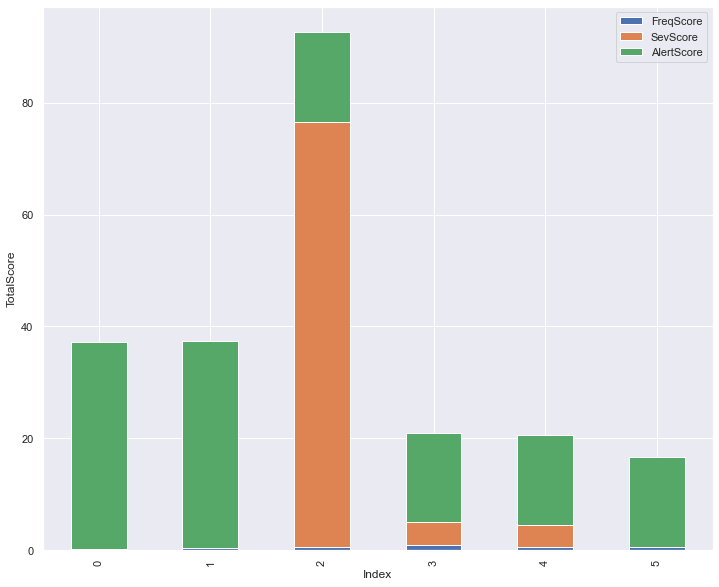

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))
plt.xlabel('Index')
plt.ylabel('TotalScore')
display(b64_analytics[['FreqScore','SevScore', 'AlertScore']].plot(ax=ax, kind='bar', stacked=True))

### Behavior Timeline

This timeline visualizes when commands occurred to identify potential windows of activity.

In [22]:
nbdisplay.display_timeline(data=b64_df, source_columns=['DecodedCommand', 'Categories'])

Loading BokehJS ...

Column(id='1661', ...)